In [1]:
import numpy as np
import time
from pyscf import scf
from pyscf.pbc import df as pdf
from pyscf.pbc import scf as pbchf
from pyscf.pbc import gto as pbcgto
from pyscf.pbc import cc as pbccc
from pyscf.pbc import tools
import matplotlib.pyplot as plt
import pandas as pd

def make_cell(dist,num_h,sep=17.479):
    atoms = []
    for i in range(num_h):
        atoms += [["H",((dist*i),0,0)]]
    cell = pbcgto.Cell()
    cell.build(a = [[num_h*dist,0,0],[0,sep,0],[0,0,sep]],
               atom = atoms,
               verbose = 0,
               basis='sto3g')
    return cell

def make_kpts(N,cell,kdover2pi=False):
    from pyscf.lib import param
    angstrom_to_bohr = 1/param.BOHR
    d = cell.a[0][0]
    if cell.unit not in ["bohr","B"]:
        d *= angstrom_to_bohr
    ks = np.arange(N)/N
    b = 2*np.pi/d
    kpts = np.zeros((N,3))
    kpts[:,0] = ks*b #Cool!
    #Returns k, to get to kd/2pi multiply by d/2pi
    if kdover2pi:
        kpts *= d/(2*np.pi)
    return kpts

def make_and_run_mf(dist,nkpts,num_h,fnal="HF"):
    cell = make_cell(dist,num_h)
    if fnal == "HF":
        mf = pbchf.KRHF(cell).density_fit()
    else:
        mf = pbchf.KRKS(cell,xc=fnal).density_fit()
    
    nkpts = nkpts
    kpts2 = cell.make_kpts([nkpts,1,1])
    kpts = make_kpts(nkpts,cell)
    assert(np.allclose(kpts,kpts2))
    mf.kpts = kpts
    mf.kernel()
    
    energies, mos = mf.get_bands(kpts)
    energies = np.vstack(energies)
    kptsnorm = make_kpts(nkpts,cell,True)[:,0]
    kptsnorm = np.hstack([kptsnorm,np.array(1)]) #append gamma at end
    df = pd.DataFrame()
    for i in range(energies.shape[1]):
        e_band = energies[:,i]
        e_band = np.hstack([e_band,np.array(e_band[0])])
        for k,e in zip(kptsnorm,e_band):
            df.loc[k,i] = e
        df.loc["nocc",i] = mf.mo_occ[0][i]
    return df

class PeriodicData: #Periodic
    def __init__(self,df):
        # self.df = pd.read_csv(csv_fn,index_col=0)
        self.df = df
        self.mo_occ = self.df.loc["nocc"]
        self.df = self.df.drop("nocc")
        self.hartree_to_ev = 27.2114

    def get_homo(self):
        df = self.df.copy()
        homo_idx = np.where(self.mo_occ == 2)[0][-1]
        k = np.array(self.df.index).astype(float)
        energies = self.df.iloc[:,homo_idx].values
        energies *= self.hartree_to_ev
        return energies,k

    def get_lumo(self):
        df = self.df.copy()
        lumo_idx = np.where(self.mo_occ == 0)[0][0]
        k = np.array(self.df.index).astype(float)
        energies = self.df.iloc[:,lumo_idx].values
        energies *= self.hartree_to_ev
        return energies,k

DIST = 1.4
NUM_H = 4
NKPTS = 16
FNAL = "PBE"
RESULTS = make_and_run_mf(DIST, NKPTS, NUM_H, FNAL)
RESULTS.to_csv(f"logs/periodic_{FNAL}_frag{NUM_H}H_14_k16.csv")

/home/king1305/Apps/pyscf/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


,IP,EA,GAP
PBE,3.44,3.43,0.01


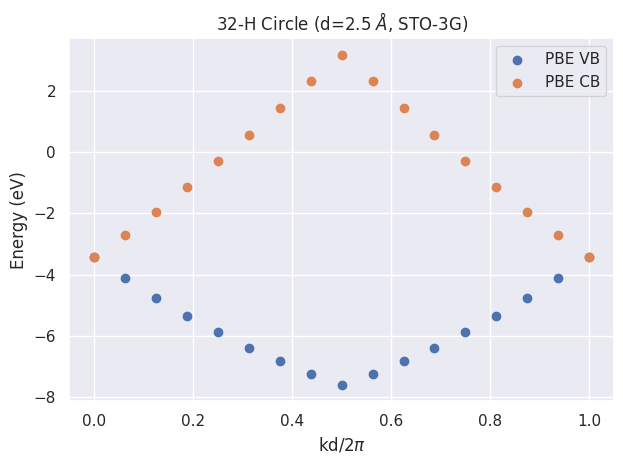

In [2]:
import seaborn as sns
sns.set()
per = PeriodicData(RESULTS)
df = pd.DataFrame()
e,k = per.get_homo()
df.loc[FNAL,"IP"] = -e.max()
plt.scatter(k,e,label=f"{FNAL} VB")
e,k = per.get_lumo()
df.loc[FNAL,"EA"] = -e.min()
df["GAP"] = (-df["EA"]) - (-df["IP"])
plt.scatter(k,e,label=f"{FNAL} CB")
plt.legend()
plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.title("32-H Circle (d=2.5 $\AA$, STO-3G)")
plt.tight_layout()
plt.savefig(f"../figures/hcircle_periodic_bands_{FNAL}.png")
np.round(df,2)